# Descriptive statistics for RNA, niche, activity and flux modalities

In [1]:
import os


# Import libraries from general conda environment
import anndata as ad
import numpy as np
import scanpy as sc
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import adjusted_rand_score, confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn import preprocessing
from scipy.optimize import linear_sum_assignment
import copy as copy
import pickle
from functools import reduce
from pathlib import Path

# Import libraries from UnitedNet
import sys
import os
from unitednet.interface import UnitedNet
from unitednet.configs import *
from unitednet.data import partitions,save_umap,generate_adata
from unitednet.scripts import ordered_cmat,assignmene_align

# Import for SHAPs
import shap
import torch
import torch.nn as nn
from unitednet.modules import submodel_trans, submodel_clus
from unitednet.data import save_obj, load_obj, type_specific_mean
from unitednet.plots import markers_chord_plot,type_relevance_chord_plot,feature_relevance_chord_plot,merge_sub_feature

# Import for plotting
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.neighbors import NearestNeighbors

# Import for more detailed plotting
import matplotlib as mpl
from  matplotlib.ticker import FuncFormatter

# Import STRINGdb for PPI network models and Networkx for visualisation and potential graph analysis
import stringdb
import networkx as nx
import math
from scipy.spatial import distance
import anndata
import scipy.sparse as sp
from sklearn.model_selection import train_test_split

2025-12-01 16:23:53.591632: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 16:23:53.598894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-01 16:23:53.606735: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-01 16:23:53.609122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-01 16:23:53.616107: I tensorflow/core/platform/cpu_feature_guar

In [8]:
import numpy as np
import pandas as pd
from scipy import sparse

def _to_csr(X):
    if sparse.issparse(X):
        return X.tocsr()
    # dense -> csr
    return sparse.csr_matrix(X, dtype=np.float64)

def _global_stats_from_sparse(X_csr):
    """
    Compute global stats over *all entries* (including zeros) without densifying.
    Returns dict with min, max, mean, std, median (approx), skew, kurt_excess, sparsity.
    Notes:
      - min/median for huge sparse mats are approximated cheaply:
        * min: 0 if any zeros exist, else min(data)
        * median: uses a quick bin-based approximation across nonzeros + zeros.
        If you prefer exact median, consider sampling or quantile sketches.
    """
    n_obs, n_vars = X_csr.shape
    N = n_obs * n_vars
    data = X_csr.data.astype(np.float64, copy=False)
    k = data.size  # nnz
    zeros = N - k

    # sums
    s1 = data.sum() if k else 0.0
    s2 = (data * data).sum() if k else 0.0

    mu = s1 / N
    # central moments using zeros explicitly
    # m2 = E[(x-μ)^2]
    m2 = ( ( (data - mu)**2 ).sum() + zeros * (mu**2) ) / N
    std = np.sqrt(m2)

    # m3, m4
    m3 = ( ( (data - mu)**3 ).sum() + zeros * ((-mu)**3) ) / N
    m4 = ( ( (data - mu)**4 ).sum() + zeros * ((-mu)**4) ) / N

    # skewness and (excess) kurtosis
    if m2 > 0:
        skew = m3 / (m2**1.5)
        kurt_excess = m4 / (m2**2) - 3.0
    else:
        skew = np.nan
        kurt_excess = np.nan

    # min / max
    # if there are zeros, global min is min(0, min(data)) ; else min(data)
    if k:
        dmin = data.min()
        dmax = data.max()
    else:
        dmin = 0.0
        dmax = 0.0
    gmin = min(0.0, dmin) if zeros > 0 else dmin
    gmax = dmax

    # simple median approximation:
    # if zeros >= N/2, median is 0. otherwise approximate from nonzeros’ median.
    if zeros * 2 >= N:
        median_approx = 0.0
    else:
        median_approx = np.median(data) if k else 0.0

    sparsity = zeros / N
    return dict(
        min=gmin, max=gmax, mean=mu, std=std,
        median_approx=median_approx,
        skewness=skew, kurtosis_excess=kurt_excess,
        sparsity=sparsity,
        nnz=int(k), total=int(N)
    )

def _rowcol_summaries(X_csr):
    """Per-cell and per-feature sparsity summaries (median, mean)."""
    n_obs, n_vars = X_csr.shape
    nnz_rows = np.diff(X_csr.indptr)                    # length n_obs
    sparsity_rows = 1.0 - (nnz_rows / n_vars)

    X_csc = X_csr.tocsc()
    nnz_cols = np.diff(X_csc.indptr)                    # length n_vars
    sparsity_cols = 1.0 - (nnz_cols / n_obs)

    return {
        "per_cell_sparsity_median": float(np.median(sparsity_rows)),
        "per_cell_sparsity_mean":   float(np.mean(sparsity_rows)),
        "per_gene_sparsity_median": float(np.median(sparsity_cols)),
        "per_gene_sparsity_mean":   float(np.mean(sparsity_cols)),
        "cells": n_obs, "features": n_vars
    }

def summarize_modality(adata, layer=None, name="modality"):
    """
    adata : AnnData
    layer : str or None
      - None -> use adata.X
      - str  -> use adata.layers[layer]
    """
    X = adata.layers[layer] if layer else adata.X
    X_csr = _to_csr(X)
    g = _global_stats_from_sparse(X_csr)
    rc = _rowcol_summaries(X_csr)
    out = {**g, **rc}
    out["modality"] = name
    out["layer"] = (layer if layer else "X")
    return out

# ---- Example (in memory) ----
# Suppose you have: adata_rna, adata_niche, adata_activity, adata_flux
# If they live as layers in ONE AnnData, call summarize_modality with layer names.

def compare_four(adata_rna=None, adata_niche=None, adata_activity=None, adata_flux=None,
                 one_adata=None, layers=dict(rna=None, niche=None, activity=None, flux=None)):
    rows = []
    if one_adata is not None:
        for mod, lay in layers.items():
            rows.append(summarize_modality(one_adata, layer=lay, name=mod.upper()))
    else:
        if adata_rna is not None:     rows.append(summarize_modality(adata_rna,     None, "RNA"))
        if adata_niche is not None:   rows.append(summarize_modality(adata_niche,   None, "NICHE"))
        if adata_activity is not None:rows.append(summarize_modality(adata_activity,None, "ACTIVITY"))
        if adata_flux is not None:    rows.append(summarize_modality(adata_flux,    None, "FLUX"))
    return pd.DataFrame(rows)

# Usage (pick ONE pattern):

# A1) Separate AnnData objects:
# df = compare_four(adata_rna=adata_rna, adata_niche=adata_niche,
#                   adata_activity=adata_activity, adata_flux=adata_flux)

# A2) One AnnData with layers:
# df = compare_four(one_adata=adata_all,
#                   layers=dict(rna="rna", niche="niche", activity="activity", flux="flux"))

# print(df.round(4))
# df.to_csv("modality_basic_stats.csv", index=False)


In [2]:
adata_rna = sc.read('../Data/processedData3/rna_modality.h5ad')
adata_niche = sc.read('../Data/processedData3/niche_modality.h5ad')
adata_activity = sc.read('../Data/processedData3/activity_modality.h5ad')
adata_flux = sc.read('../Data/processedData3/flux_modality.h5ad')

In [7]:
print(adata_rna)
print(adata_niche)
print(adata_activity)
print(adata_flux)

AnnData object with n_obs × n_vars = 407 × 2504
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 407 × 2504
    obs: 'in_tissue', 'array_row', 'array_col', 

In [10]:
df = compare_four(adata_rna=adata_rna, adata_niche=adata_niche,
                  adata_activity=adata_activity, adata_flux=adata_flux)

df

min       max      mean       std  median_approx  skewness  \
0  0.00000  6.771685  0.133867  0.357060       0.000000  5.299158   
1  0.00000  5.389122  0.133077  0.323582       0.084903  5.828760   
2  0.00000  4.667249  0.216228  0.234969       0.238280  3.024686   
3 -0.04256  0.057390  0.002550  0.011699       0.000673  0.419558   

   kurtosis_excess  sparsity     nnz    total  per_cell_sparsity_median  \
0        40.732231  0.725700  279547  1019128                  0.723642   
1        47.558011  0.360926  651298  1019128                  0.359026   
2        21.419179  0.273746  739850  1018721                  0.234119   
3        -0.174638  0.000000   21770    21770                  0.000000   

   per_cell_sparsity_mean  per_gene_sparsity_median  per_gene_sparsity_mean  \
0                0.725700                  0.835381                0.725700   
1                0.360926                  0.127764                0.360926   
2                0.273746                  0.122850                0.273746   
3                0.000000                  0.000000                0.000000   

   cells  features  modality layer  
0    407      2504       RNA     X  
1    407      2504     NICHE     X  
2    407      2503  ACTIVITY     X  
3    311        70      FLUX     X

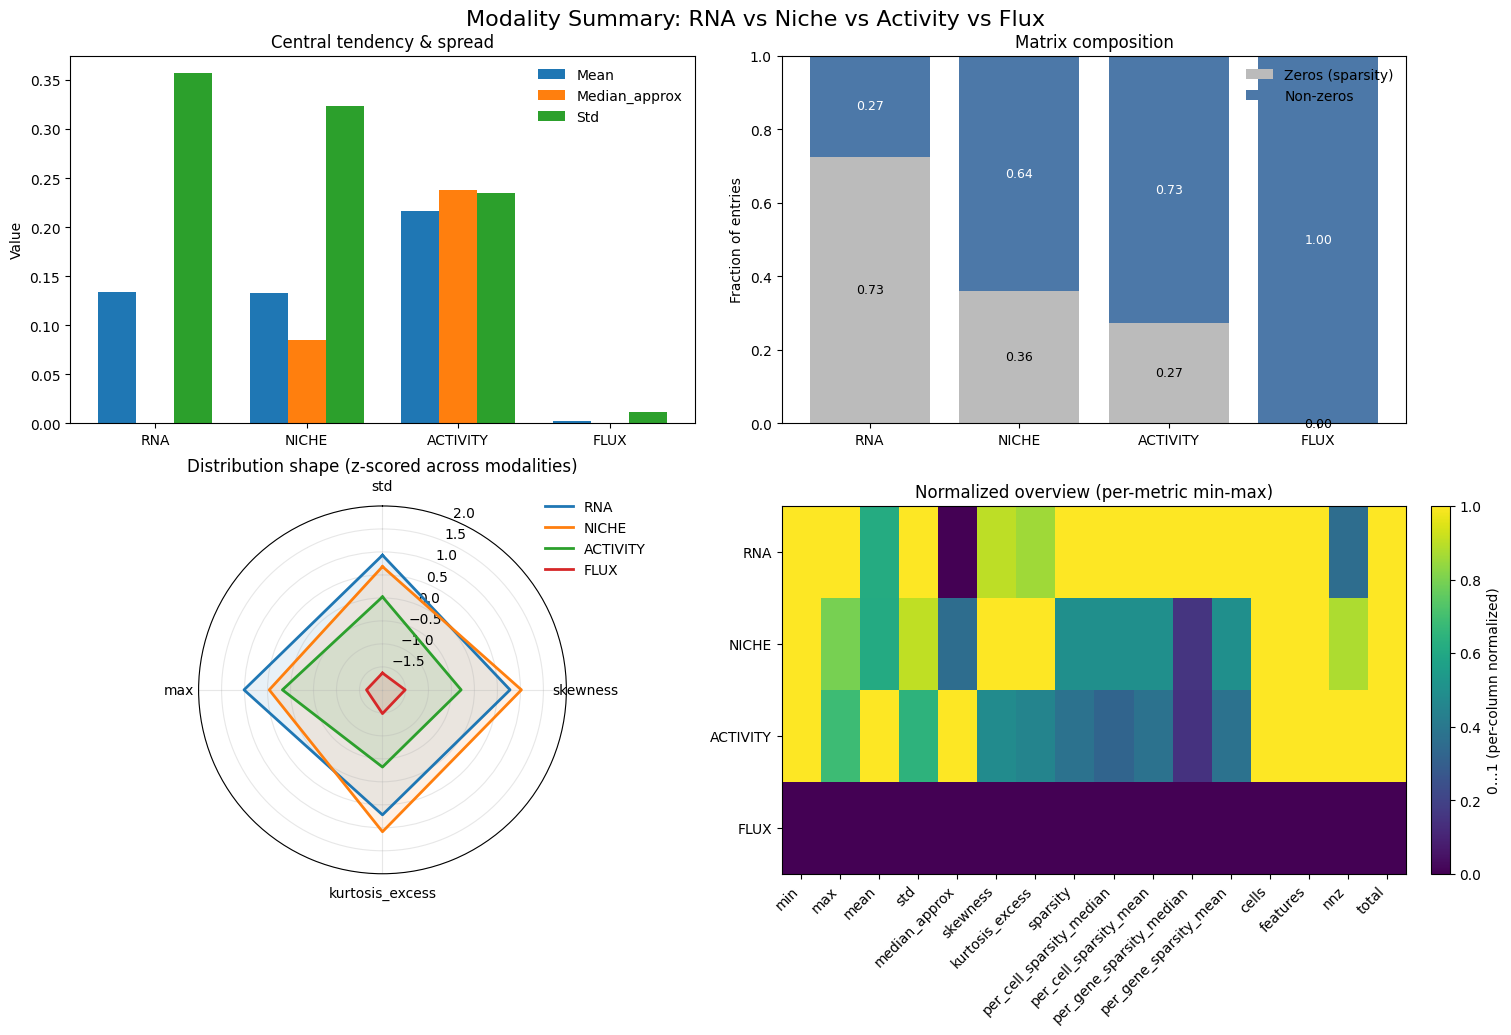

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# ------------ CONFIG ------------
MOD_ORDER = ["RNA", "NICHE", "ACTIVITY", "FLUX"]  # reorder as you like
MOMENT_COLS = ["mean", "median_approx", "std"]
SPARSITY_PARTS = ["sparsity"]  # (zeros / total) — we’ll derive nonzeros = 1 - sparsity
RADAR_COLS = ["std", "skewness", "kurtosis_excess", "max"]
HEATMAP_COLS = [
    "min","max","mean","std","median_approx",
    "skewness","kurtosis_excess","sparsity",
    "per_cell_sparsity_median","per_cell_sparsity_mean",
    "per_gene_sparsity_median","per_gene_sparsity_mean",
    "cells","features","nnz","total"
]
TITLE = "Modality Summary: RNA vs Niche vs Activity vs Flux"

# ------------ PREP ------------
df_plot = df.copy()
if "modality" not in df_plot.columns:
    raise ValueError("Expected a 'modality' column in df")

# enforce order if all present
present = [m for m in MOD_ORDER if m in df_plot["modality"].tolist()]
if present:
    df_plot["__order__"] = df_plot["modality"].map({m:i for i,m in enumerate(MOD_ORDER)})
    df_plot = df_plot.sort_values("__order__")
else:
    df_plot["__order__"] = np.arange(len(df_plot))

# palette (consistent, color-blind friendly)
colors = mpl.cm.tab10(np.linspace(0, 1, len(df_plot)))

# ------------ FIGURE LAYOUT ------------
fig = plt.figure(figsize=(15, 10), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

# ========== (A) Core moments: grouped bars ==========
axA = fig.add_subplot(gs[0, 0])
x = np.arange(len(df_plot))
w = 0.25

for j, col in enumerate(MOMENT_COLS):
    axA.bar(x + (j-1)*w, df_plot[col].values, width=w, label=col.capitalize())

axA.set_xticks(x)
axA.set_xticklabels(df_plot["modality"], rotation=0)
axA.set_title("Central tendency & spread")
axA.set_ylabel("Value")
axA.legend(frameon=False)

# ========== (B) Sparsity composition: stacked bars ==========
axB = fig.add_subplot(gs[0, 1])
zeros = df_plot["sparsity"].values
nonzeros = 1.0 - zeros
axB.bar(df_plot["modality"], zeros, label="Zeros (sparsity)", color="#bbbbbb")
axB.bar(df_plot["modality"], nonzeros, bottom=zeros, label="Non-zeros", color="#4c78a8")
axB.set_ylim(0, 1)
axB.set_ylabel("Fraction of entries")
axB.set_title("Matrix composition")
for i,(z,nz) in enumerate(zip(zeros, nonzeros)):
    axB.text(i, z/2, f"{z:.2f}", ha="center", va="center", fontsize=9, color="black")
    axB.text(i, z + nz/2, f"{nz:.2f}", ha="center", va="center", fontsize=9, color="white")
axB.legend(frameon=False)

# ========== (C) Radar: standardized “shape” metrics ==========
# Normalize RADAR_COLS across modalities (z-score) so scales are comparable
radar_df = df_plot[["modality"] + RADAR_COLS].set_index("modality").astype(float)
radar_norm = (radar_df - radar_df.mean()) / radar_df.std(ddof=0)
labels = RADAR_COLS
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # loop back

axC = fig.add_subplot(gs[1, 0], polar=True)
axC.set_title("Distribution shape (z-scored across modalities)")
axC.set_theta_offset(np.pi / 2)
axC.set_theta_direction(-1)

axC.set_xticks(angles[:-1])
axC.set_xticklabels(labels)
# reasonable radial limits for z-scores
rmin, rmax = np.nanmin(radar_norm.values), np.nanmax(radar_norm.values)
r = max(abs(rmin), abs(rmax))
axC.set_ylim(-max(2, r*1.1), max(2, r*1.1))
axC.grid(alpha=0.3)

for i,(mod,row) in enumerate(radar_norm.iterrows()):
    vals = row.values.tolist()
    vals += vals[:1]
    axC.plot(angles, vals, linewidth=2, label=mod)
    axC.fill(angles, vals, alpha=0.1)

axC.legend(loc="upper right", bbox_to_anchor=(1.25, 1.05), frameon=False)

# ========== (D) Heatmap: column-wise min-max = [0,1] ==========
axD = fig.add_subplot(gs[1, 1])
heat_df = df_plot.set_index("modality")[HEATMAP_COLS].astype(float)
# robust min-max (guard against constant columns)
hmin = heat_df.min(axis=0)
hmax = heat_df.max(axis=0)
rng = (hmax - hmin).replace(0, 1.0)
heat01 = (heat_df - hmin) / rng

im = axD.imshow(heat01.values, aspect="auto", cmap="viridis")
axD.set_yticks(np.arange(len(heat01.index)))
axD.set_yticklabels(heat01.index)
axD.set_xticks(np.arange(len(heat01.columns)))
axD.set_xticklabels(heat01.columns, rotation=45, ha="right")
axD.set_title("Normalized overview (per-metric min-max)")

cbar = fig.colorbar(im, ax=axD, fraction=0.046, pad=0.04)
cbar.set_label("0…1 (per-column normalized)")

fig.suptitle(TITLE, fontsize=16, y=1.02)
plt.show()


In [14]:
# histograms_four_modalities.py
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from typing import Optional, Dict, Tuple

# ---------- helpers ----------
def _to_csr(X):
    return X.tocsr() if sparse.issparse(X) else sparse.csr_matrix(X, dtype=np.float64)

def _central_moments_sparse_allentries(X_csr) -> Tuple[float,float,float,float,float,float]:
    """Return (mean, std, skew, kurt_excess, sparsity, max) over ALL entries (incl. zeros)."""
    n_obs, n_vars = X_csr.shape
    N = n_obs * n_vars
    data = X_csr.data.astype(np.float64, copy=False)
    k = data.size
    zeros = N - k

    s1 = data.sum() if k else 0.0
    mu = s1 / N

    # central moments with zeros explicitly
    d = data - mu
    m2 = (d @ d) + zeros * (mu**2)
    m3 = (d**3).sum() + zeros * ((-mu)**3)
    m4 = (d**4).sum() + zeros * ((-mu)**4)
    m2 /= N; m3 /= N; m4 /= N
    if m2 > 0:
        std = np.sqrt(m2)
        skew = m3 / (m2**1.5)
        kurt_excess = m4 / (m2**2) - 3.0
    else:
        std = 0.0; skew = np.nan; kurt_excess = np.nan

    sparsity = zeros / N
    xmax = float(data.max()) if k else 0.0
    return mu, std, skew, kurt_excess, sparsity, xmax

def _sample_all_entries_for_hist(X_csr, max_points=400_000, include_zeros=True, random_state=0):
    """
    Return a 1D sample of matrix entries for plotting histograms without densifying.
    Keeps all nonzeros if small; otherwise downsamples nonzeros and (optionally) zeros.
    """
    rng = np.random.default_rng(random_state)
    n_obs, n_vars = X_csr.shape
    N = n_obs * n_vars
    data = X_csr.data.astype(np.float64, copy=False)
    k = data.size
    z = N - k

    # decide sample sizes
    target = min(N, max_points)
    # proportional sampling between zeros and nonzeros
    if include_zeros:
        p_nz = k / N if N > 0 else 0
        n_nz = int(round(p_nz * target))
        n_z  = target - n_nz
    else:
        n_nz = min(k, target)
        n_z = 0

    # sample nonzeros
    if k <= n_nz:
        nz_sample = data
    else:
        idx = rng.choice(k, size=n_nz, replace=False)
        nz_sample = data[idx]

    if n_z <= 0:
        return nz_sample

    # zeros are just zeros; no need to pull positions
    z_sample = np.zeros(n_z, dtype=np.float64)
    return np.concatenate([nz_sample, z_sample], axis=0)

# ---------- main plotting ----------
def plot_histograms_by_modality(
    rna=None, niche=None, activity=None, flux=None,
    one_adata=None, layers: Optional[Dict[str, Optional[str]]]=None,
    title="Descriptive statistics for the Perturb-Map modalities",
    bins=80, logx=False, include_zeros=True, max_points=400_000,
    sharex=False, sharey=False, random_state=0
):
    """
    Provide either separate AnnData objects (rna/niche/activity/flux) OR one AnnData + layers dict:
      layers = {"RNA": "rna_layer", "NICHE": "niche_layer", "ACTIVITY": "activity_layer", "FLUX": "flux_layer"}
      Use None in a layer to use .X
    """
    import anndata as ad  # only needed for type hints; not used directly

    mods = []
    if one_adata is not None and layers is not None:
        for name, layer in [("RNA","rna"), ("NICHE","niche"), ("ACTIVITY","activity"), ("FLUX","flux")]:
            if name in layers or layers.get(name) is not None or name in ["RNA","NICHE","ACTIVITY","FLUX"]:
                X = one_adata.layers[layers[name]] if layers.get(name) else one_adata.X
                mods.append((name, _to_csr(X)))
    else:
        if rna is not None:      mods.append(("RNA", _to_csr(rna.X)))
        if niche is not None:    mods.append(("NICHE", _to_csr(niche.X)))
        if activity is not None: mods.append(("ACTIVITY", _to_csr(activity.X)))
        if flux is not None:     mods.append(("FLUX", _to_csr(flux.X)))

    if not mods:
        raise ValueError("No modalities provided.")

    # figure
    n = len(mods)
    rows = 2 if n > 2 else 1
    cols = 2 if n > 1 else 1
    fig, axes = plt.subplots(rows, cols, figsize=(12, 7), squeeze=False, sharex=sharex, sharey=sharey)
    axes = axes.ravel()

    for ax, (name, X_csr) in zip(axes, mods):
        # stats (incl. zeros)
        mean, std, skew, kurt_ex, sparsity, xmax = _central_moments_sparse_allentries(X_csr)

        # sample values for histogram
        vals = _sample_all_entries_for_hist(
            X_csr, max_points=max_points, include_zeros=include_zeros, random_state=random_state
        )

        # optional transform
        plot_vals = np.log1p(vals) if logx else vals

        ax.hist(plot_vals, bins=bins)
        ax.set_title(name)
        ax.set_xlabel("log1p(value)" if logx else "value")
        ax.set_ylabel("count")

        # annotation box
        txt = (
            f"skew = {skew:0.3f}\n"
            f"kurt(excess) = {kurt_ex:0.3f}\n"
            f"mean = {mean:0.3f}, std = {std:0.3f}\n"
            f"sparsity = {sparsity:0.3f}"
        )
        ax.text(0.98, 0.98, txt, ha="right", va="top",
                transform=ax.transAxes, fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.5", alpha=0.85))

    # clean unused axes if <4 modalities
    for j in range(len(mods), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title, y=0.98, fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

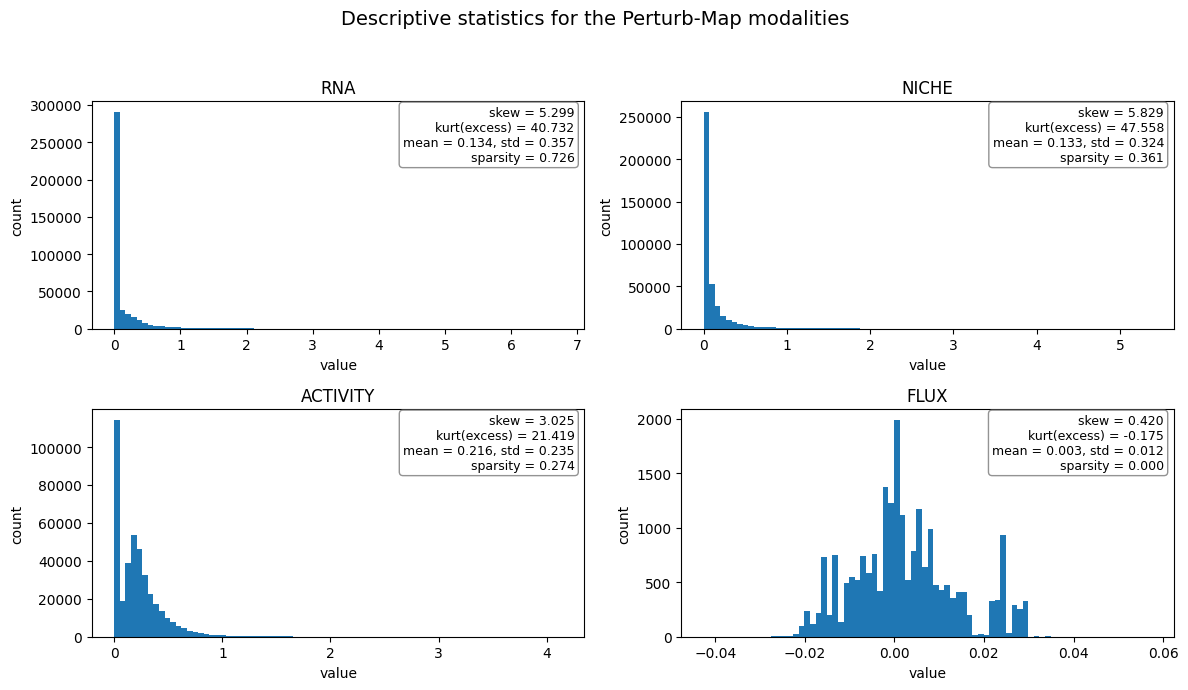

In [15]:
plot_histograms_by_modality(
    rna=adata_rna, niche=adata_niche, activity=adata_activity, flux=adata_flux,
    bins=80, logx=False, include_zeros=True, max_points=400_000
)

# Spatial Auto-correlation

In [4]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load all modalities
modality_paths = {
    'RNA': '../Data/processedData3/rna_modality.h5ad',
    'Niche': '../Data/processedData3/niche_modality.h5ad',
    'Activity': '../Data/processedData3/activity_modality.h5ad',
    'Flux': '../Data/processedData3/flux_modality.h5ad'
}

adata_dict = {name: sc.read(path) for name, path in modality_paths.items()}

# Check that all have spatial coordinates
print("Checking spatial coordinates...")
for name, adata in adata_dict.items():
    print(f"{name}: {adata.shape}, has spatial: {'spatial' in adata.obsm}")

# Build spatial neighbors graph (use RNA as reference, should be same for all)
print("\nBuilding spatial neighbors graph...")
reference_adata = adata_dict['RNA']

# Option 1: If you have 2D spatial coordinates
if 'spatial' in reference_adata.obsm:
    sc.pp.neighbors(reference_adata, use_rep='spatial', n_neighbors=6)
else:
    # Option 2: If coordinates are in obs columns
    if 'x' in reference_adata.obs.columns and 'y' in reference_adata.obs.columns:
        reference_adata.obsm['spatial'] = reference_adata.obs[['x', 'y']].values
        sc.pp.neighbors(reference_adata, use_rep='spatial', n_neighbors=6)
    else:
        print("Warning: No spatial coordinates found!")

# Extract the spatial connectivity graph
spatial_graph = reference_adata.obsp['connectivities']

# Calculate Moran's I for each modality
morans_results = {}

for modality_name, adata in adata_dict.items():
    print(f"\nCalculating Moran's I for {modality_name}...")
    
    # Get the data matrix
    # Transpose to (n_features, n_cells) as required by scanpy
    if modality_name == 'RNA':
        # For RNA, might want to use only highly variable genes
        if 'highly_variable' in adata.var.columns:
            genes_to_use = adata.var_names[adata.var.highly_variable]
            X = adata[:, genes_to_use].X.T
        else:
            X = adata.X.T
    else:
        # For other modalities, use all features
        X = adata.X.T
    
    # Convert to dense if sparse
    if hasattr(X, 'toarray'):
        X = X.toarray()
    
    # Calculate Moran's I
    morans = sc.metrics.morans_i(spatial_graph, vals=X)
    
    # Store results
    morans_results[modality_name] = morans
    
    print(f"  {modality_name}: n_features={len(morans)}, "
          f"mean={np.mean(morans):.3f}, "
          f"median={np.median(morans):.3f}")

# Create combined dataframe for analysis
results_list = []
for modality_name, morans_vals in morans_results.items():
    for i, val in enumerate(morans_vals):
        results_list.append({
            'Modality': modality_name,
            'Moran_I': val,
            'Feature_idx': i
        })

results_df = pd.DataFrame(results_list)

# Summary statistics
print("\n" + "="*60)
print("Summary Statistics by Modality")
print("="*60)
summary = results_df.groupby('Modality')['Moran_I'].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std', 'std'),
    ('Min', 'min'),
    ('Max', 'max')
]).round(3)
print(summary)

# Save results
results_df.to_csv('morans_i_results.csv', index=False)
summary.to_csv('morans_i_summary.csv')
print("\nResults saved to CSV files")

Checking spatial coordinates...
RNA: (407, 1004), has spatial: True
Niche: (407, 1004), has spatial: True
Activity: (407, 1004), has spatial: True
Flux: (407, 70), has spatial: True

Building spatial neighbors graph...

Calculating Moran's I for RNA...
  RNA: n_features=238, mean=0.230, median=0.162

Calculating Moran's I for Niche...
  Niche: n_features=1004, mean=0.790, median=0.808

Calculating Moran's I for Activity...
  Activity: n_features=1004, mean=0.453, median=0.441

Calculating Moran's I for Flux...
  Flux: n_features=70, mean=0.138, median=0.075

Summary Statistics by Modality
          Count   Mean  Median    Std    Min    Max
Modality                                           
Activity   1004  0.453   0.441  0.186 -0.032  0.881
Flux         70  0.138   0.075  0.172 -0.043  0.732
Niche      1004  0.790   0.808  0.138  0.348  1.023
RNA         238  0.230   0.162  0.243 -0.040  0.888

Results saved to CSV files


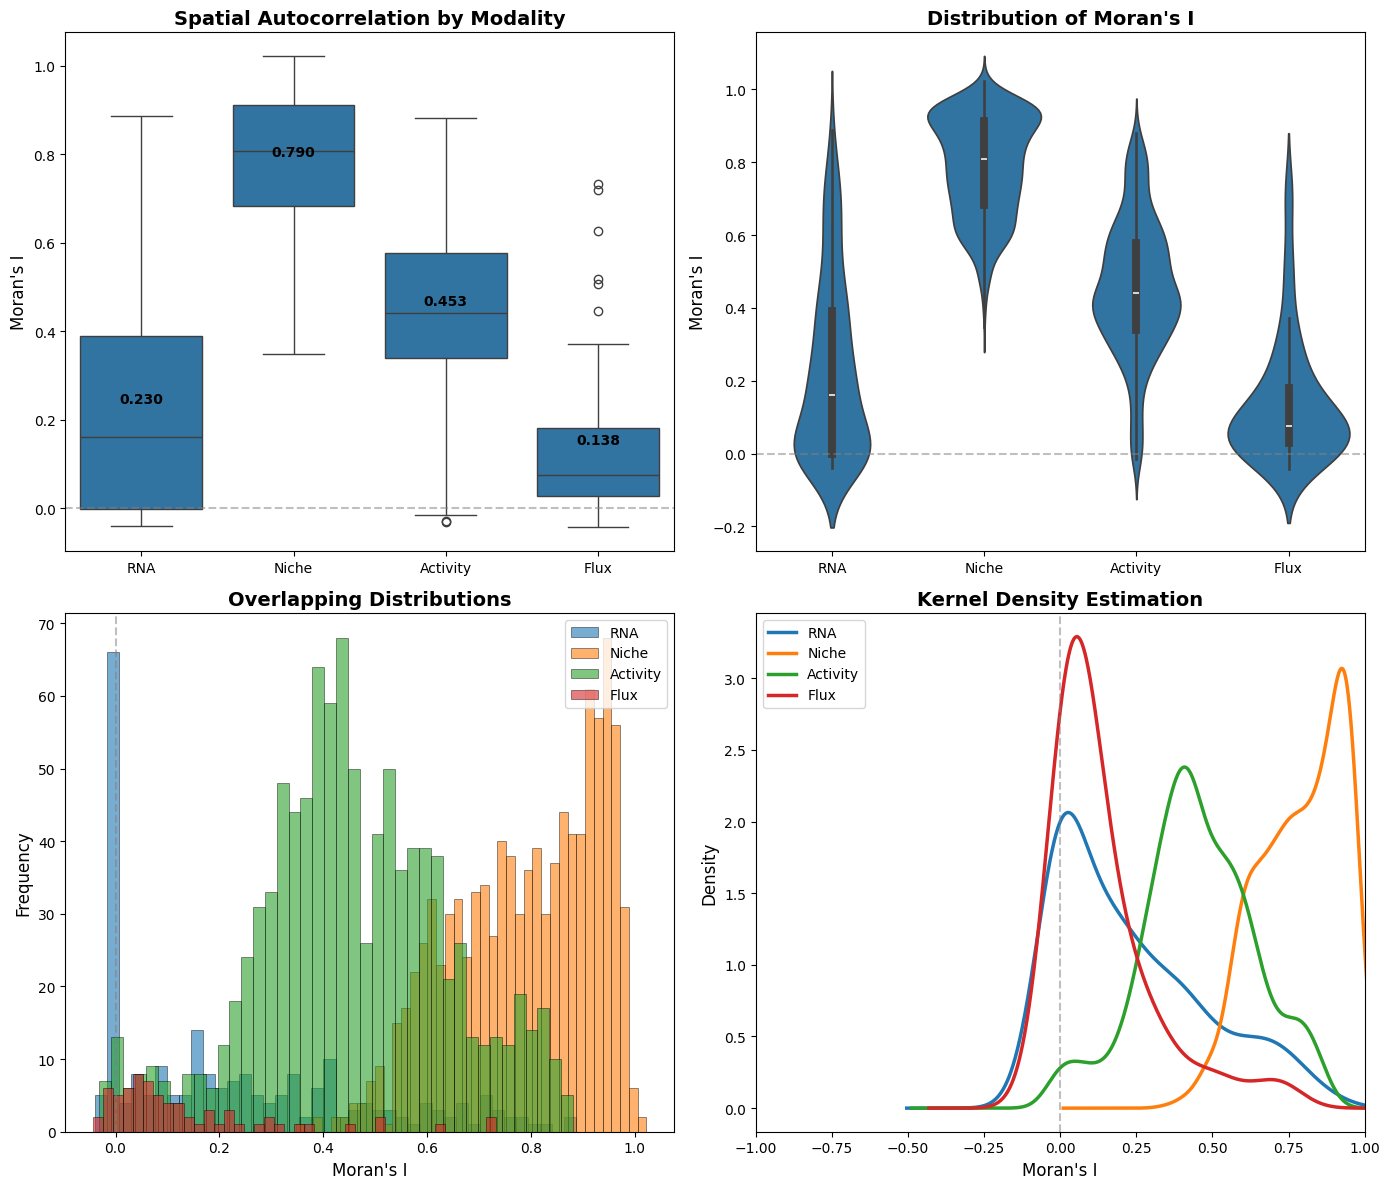


Figure saved as 'morans_i_comprehensive.pdf/png'


In [5]:
# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Panel 1: Boxplot comparison
ax = axes[0, 0]
sns.boxplot(data=results_df, x='Modality', y='Moran_I', ax=ax,
            order=['RNA', 'Niche', 'Activity', 'Flux'])
ax.axhline(0, ls='--', color='gray', alpha=0.5)
ax.set_title("Spatial Autocorrelation by Modality", fontsize=14, fontweight='bold')
ax.set_ylabel("Moran's I", fontsize=12)
ax.set_xlabel("")

# Add mean values as text
means = results_df.groupby('Modality')['Moran_I'].mean()
for i, modality in enumerate(['RNA', 'Niche', 'Activity', 'Flux']):
    if modality in means:
        ax.text(i, means[modality], f'{means[modality]:.3f}', 
               ha='center', va='bottom', fontweight='bold', fontsize=10)

# Panel 2: Violin plot with individual points
ax = axes[0, 1]
sns.violinplot(data=results_df, x='Modality', y='Moran_I', ax=ax,
              order=['RNA', 'Niche', 'Activity', 'Flux'], inner='box')
ax.axhline(0, ls='--', color='gray', alpha=0.5)
ax.set_title("Distribution of Moran's I", fontsize=14, fontweight='bold')
ax.set_ylabel("Moran's I", fontsize=12)
ax.set_xlabel("")

# Panel 3: Density/histogram comparison
ax = axes[1, 0]
colors = {'RNA': '#1f77b4', 'Niche': '#ff7f0e', 'Activity': '#2ca02c', 'Flux': '#d62728'}
for modality in ['RNA', 'Niche', 'Activity', 'Flux']:
    if modality in results_df['Modality'].values:
        data = results_df[results_df['Modality'] == modality]['Moran_I']
        ax.hist(data, alpha=0.6, label=modality, bins=40, 
               color=colors[modality], edgecolor='black', linewidth=0.5)

ax.axvline(0, ls='--', color='gray', alpha=0.5)
ax.set_xlabel("Moran's I", fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Overlapping Distributions', fontsize=14, fontweight='bold')
ax.legend(frameon=True)

# Panel 4: KDE comparison
ax = axes[1, 1]
for modality in ['RNA', 'Niche', 'Activity', 'Flux']:
    if modality in results_df['Modality'].values:
        data = results_df[results_df['Modality'] == modality]['Moran_I']
        data.plot.kde(ax=ax, label=modality, linewidth=2.5, color=colors[modality])

ax.axvline(0, ls='--', color='gray', alpha=0.5)
ax.set_xlabel("Moran's I", fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Kernel Density Estimation', fontsize=14, fontweight='bold')
ax.legend(frameon=True)
ax.set_xlim(-1, 1)

plt.tight_layout()
plt.savefig('morans_i_comprehensive.pdf', dpi=300, bbox_inches='tight')
plt.savefig('morans_i_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure saved as 'morans_i_comprehensive.pdf/png'")

In [6]:
from scipy import stats

# Pairwise comparisons
modalities = ['RNA', 'Niche', 'Activity', 'Flux']
print("\n" + "="*60)
print("Pairwise Statistical Comparisons (Mann-Whitney U test)")
print("="*60)

for i, mod1 in enumerate(modalities):
    for mod2 in modalities[i+1:]:
        if mod1 in results_df['Modality'].values and mod2 in results_df['Modality'].values:
            data1 = results_df[results_df['Modality'] == mod1]['Moran_I']
            data2 = results_df[results_df['Modality'] == mod2]['Moran_I']
            
            statistic, pval = stats.mannwhitneyu(data1, data2, alternative='two-sided')
            fold_change = data2.mean() / data1.mean() if data1.mean() != 0 else np.nan
            
            print(f"\n{mod1} vs {mod2}:")
            print(f"  Mean: {data1.mean():.3f} vs {data2.mean():.3f}")
            print(f"  Fold change: {fold_change:.2f}x")
            print(f"  U-statistic: {statistic:.2f}")
            print(f"  p-value: {pval:.2e}")
            print(f"  Significant: {'***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else 'ns'}")


Pairwise Statistical Comparisons (Mann-Whitney U test)

RNA vs Niche:
  Mean: 0.230 vs 0.790
  Fold change: 3.43x
  U-statistic: 9639.00
  p-value: 5.22e-108
  Significant: ***

RNA vs Activity:
  Mean: 0.230 vs 0.453
  Fold change: 1.97x
  U-statistic: 54898.00
  p-value: 1.58e-38
  Significant: ***

RNA vs Flux:
  Mean: 0.230 vs 0.138
  Fold change: 0.60x
  U-statistic: 9670.00
  p-value: 4.08e-02
  Significant: *

Niche vs Activity:
  Mean: 0.790 vs 0.453
  Fold change: 0.57x
  U-statistic: 931006.00
  p-value: 6.01e-237
  Significant: ***

Niche vs Flux:
  Mean: 0.790 vs 0.138
  Fold change: 0.18x
  U-statistic: 69393.00
  p-value: 1.99e-42
  Significant: ***

Activity vs Flux:
  Mean: 0.453 vs 0.138
  Fold change: 0.31x
  U-statistic: 62328.00
  p-value: 2.34e-27
  Significant: ***


In [25]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load modalities
modality_paths = {
    'RNA': '../Data/processedData3/rna_modality.h5ad',
    'Niche': '../Data/processedData3/niche_modality.h5ad',
    'Activity': '../Data/processedData3/activity_modality.h5ad',
    'Flux': '../Data/processedData3/flux_modality.h5ad'
}

adata_dict = {name: sc.read(path) for name, path in modality_paths.items()}

# Clean feature names for Activity modality
def clean_feature_names(var_names, suffixes_to_remove=['_SIG', '_TF']):
    """
    Remove specified suffixes from feature names
    """
    cleaned_names = []
    for name in var_names:
        cleaned = name
        for suffix in suffixes_to_remove:
            if cleaned.endswith(suffix):
                cleaned = cleaned[:-len(suffix)]
        cleaned_names.append(cleaned)
    return cleaned_names

# Apply cleaning to Activity modality
if 'Activity' in adata_dict:
    adata_activity = adata_dict['Activity']
    original_names = adata_activity.var_names.tolist()
    cleaned_names = clean_feature_names(original_names)
    
    # Store original names if needed later
    adata_activity.var['original_name'] = original_names
    adata_activity.var_names = cleaned_names
    
    print(f"\nCleaned {len(original_names)} Activity feature names")
    print("Examples of cleaned names:")
    for i in range(min(5, len(original_names))):
        if original_names[i] != cleaned_names[i]:
            print(f"  {original_names[i]} -> {cleaned_names[i]}")

# Build spatial graph
reference_adata = adata_dict['RNA']
if 'spatial' in reference_adata.obsm:
    sc.pp.neighbors(reference_adata, use_rep='spatial', n_neighbors=6)
else:
    reference_adata.obsm['spatial'] = reference_adata.obs[['x', 'y']].values
    sc.pp.neighbors(reference_adata, use_rep='spatial', n_neighbors=6)

spatial_graph = reference_adata.obsp['connectivities']

# Calculate Moran's I and get top features
def get_top_spatial_features(adata, spatial_graph, n_top=20):
    """
    Get top N spatially correlated features
    """
    X = adata.X.T
    if hasattr(X, 'toarray'):
        X = X.toarray()
    
    morans = sc.metrics.morans_i(spatial_graph, vals=X)
    
    feature_morans = pd.DataFrame({
        'Feature': adata.var_names,
        'Moran_I': morans
    })
    
    feature_morans = feature_morans.sort_values('Moran_I', ascending=False)
    top_features = feature_morans.head(n_top).reset_index(drop=True)
    top_features['Rank'] = range(1, n_top + 1)
    
    return top_features

# Get top 10 for each modality
top_features_dict = {}
all_top_features = []

for modality_name, adata in adata_dict.items():
    print(f"\nCalculating top spatial features for {modality_name}...")
    top_features = get_top_spatial_features(adata, spatial_graph, n_top=20)
    top_features['Modality'] = modality_name
    
    top_features_dict[modality_name] = top_features
    all_top_features.append(top_features)
    
    print(f"\nTop 10 Spatially Correlated Features in {modality_name}:")
    print(top_features[['Rank', 'Feature', 'Moran_I']].to_string(index=False))

# Combine all results
combined_top_features = pd.concat(all_top_features, ignore_index=True)
combined_top_features.to_csv('top_spatial_features_by_modality.csv', index=False)


Cleaned 1004 Activity feature names
Examples of cleaned names:
  2810006K23Rik_SIG -> 2810006K23Rik
  3110001I22Rik_SIG -> 3110001I22Rik
  4931428L18Rik_SIG -> 4931428L18Rik
  9930021J03Rik_SIG -> 9930021J03Rik
  a_SIG -> a

Calculating top spatial features for RNA...

Top 10 Spatially Correlated Features in RNA:
 Rank Feature  Moran_I
    1   Clca1 0.887860
    2   Lypd8 0.883398
    3     Tnc 0.821477
    4    Gzme 0.815830
    5  Ighg2c 0.794442
    6   Timp1 0.791529
    7    Scd1 0.769050
    8  Lgals2 0.766624
    9   Dmbt1 0.759606
   10  Sftpa1 0.754426
   11   Chil1 0.752117
   12     Eln 0.751816
   13   Fbln2 0.740533
   14   Sftpb 0.735870
   15    Igkc 0.729706
   16  Retnla 0.723833
   17   Ighg1 0.723474
   18 Scgb1a1 0.723107
   19   Mcpt8 0.723042
   20  Ighg2b 0.709775

Calculating top spatial features for Niche...

Top 10 Spatially Correlated Features in Niche:
 Rank    Feature  Moran_I
    1      Ecrg4 1.022649
    2       Gzme 1.011784
    3      Ighg3 1.002090
  

In [24]:
top_features_dict

{'RNA':   Feature   Moran_I  Rank Modality
 0   Clca1  0.887860     1      RNA
 1   Lypd8  0.883398     2      RNA
 2     Tnc  0.821477     3      RNA
 3    Gzme  0.815830     4      RNA
 4  Ighg2c  0.794442     5      RNA
 5   Timp1  0.791529     6      RNA
 6    Scd1  0.769050     7      RNA
 7  Lgals2  0.766624     8      RNA
 8   Dmbt1  0.759606     9      RNA
 9  Sftpa1  0.754426    10      RNA,
 'Niche':    Feature   Moran_I  Rank Modality
 0    Ecrg4  1.022649     1    Niche
 1     Gzme  1.011784     2    Niche
 2    Ighg3  1.002090     3    Niche
 3    Mcpt8  1.000007     4    Niche
 4    Mcpt1  0.998130     5    Niche
 5     Mmp7  0.992138     6    Niche
 6  Scgb1a1  0.991036     7    Niche
 7   Ighg2c  0.990197     8    Niche
 8    Mcpt2  0.987930     9    Niche
 9    Clca1  0.987783    10    Niche,
 'Activity':     Feature   Moran_I  Rank  Modality
 0     Rspo3  0.881240     1  Activity
 1      Tph1  0.869609     2  Activity
 2  Adamts16  0.868602     3  Activity
 3     Gnrh

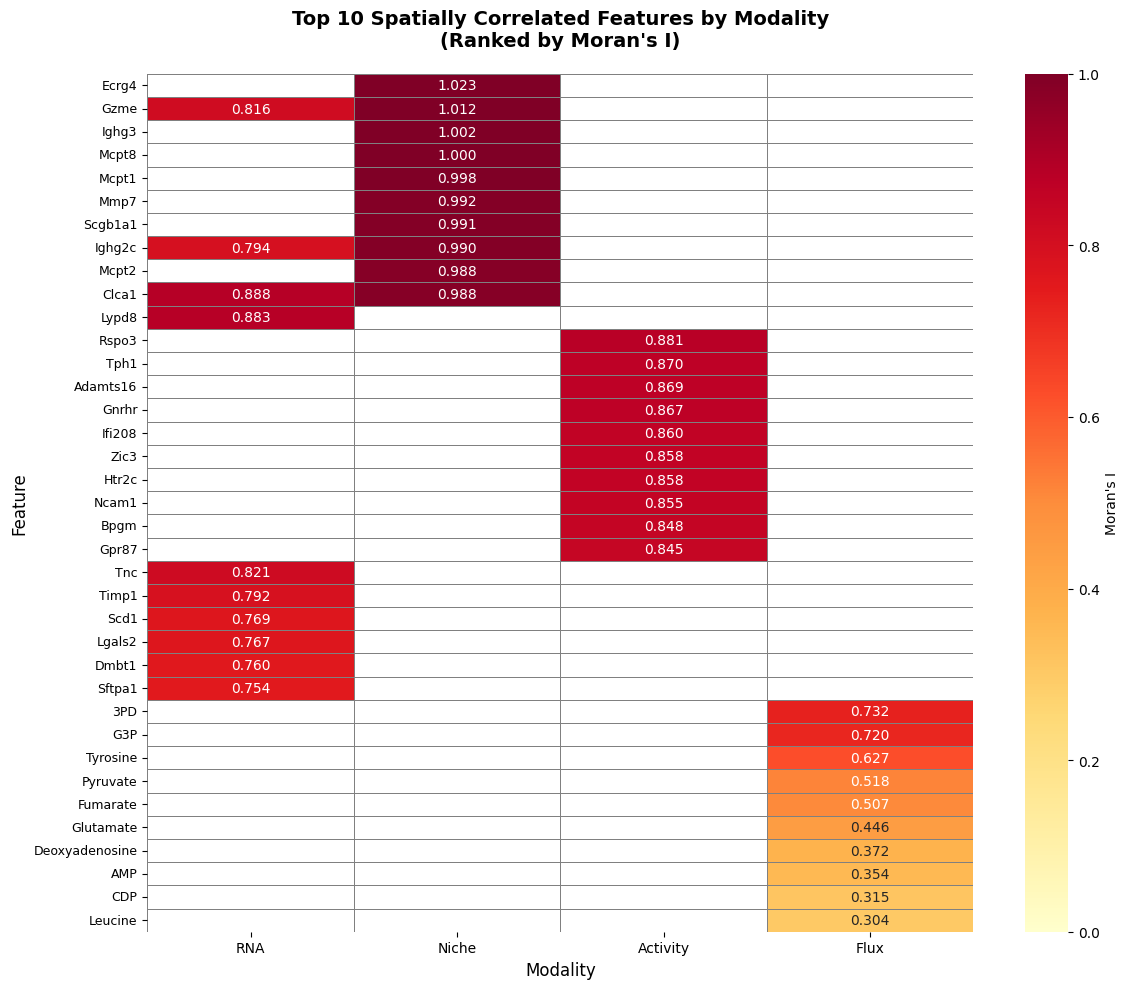

In [10]:
# Create improved heatmap comparing top features across modalities
fig, ax = plt.subplots(figsize=(12, 10))

# Get unique features from all top 10 lists
all_features = combined_top_features['Feature'].unique()

# Create matrix for heatmap
heatmap_data = combined_top_features.pivot_table(
    index='Feature', 
    columns='Modality', 
    values='Moran_I',
    fill_value=np.nan  # Use NaN instead of 0 for features not in top 10
)

# Reorder columns
column_order = ['RNA', 'Niche', 'Activity', 'Flux']
heatmap_data = heatmap_data[[col for col in column_order if col in heatmap_data.columns]]

# Sort rows by maximum Moran's I across modalities
heatmap_data['max_moran'] = heatmap_data.max(axis=1)
heatmap_data = heatmap_data.sort_values('max_moran', ascending=False)
heatmap_data = heatmap_data.drop('max_moran', axis=1)

# Create heatmap with better styling
sns.heatmap(heatmap_data, 
            annot=True, 
            fmt='.3f', 
            cmap='YlOrRd', 
            ax=ax, 
            cbar_kws={'label': "Moran's I"},
            linewidths=0.5, 
            linecolor='gray',
            mask=heatmap_data.isna(),  # Mask NaN values
            vmin=0, 
            vmax=1)

ax.set_title('Top 10 Spatially Correlated Features by Modality\n(Ranked by Moran\'s I)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Modality', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)

# Rotate y-axis labels for better readability
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)

plt.tight_layout()
plt.savefig('top_spatial_features_heatmap_cleaned.pdf', dpi=300, bbox_inches='tight')
plt.show()

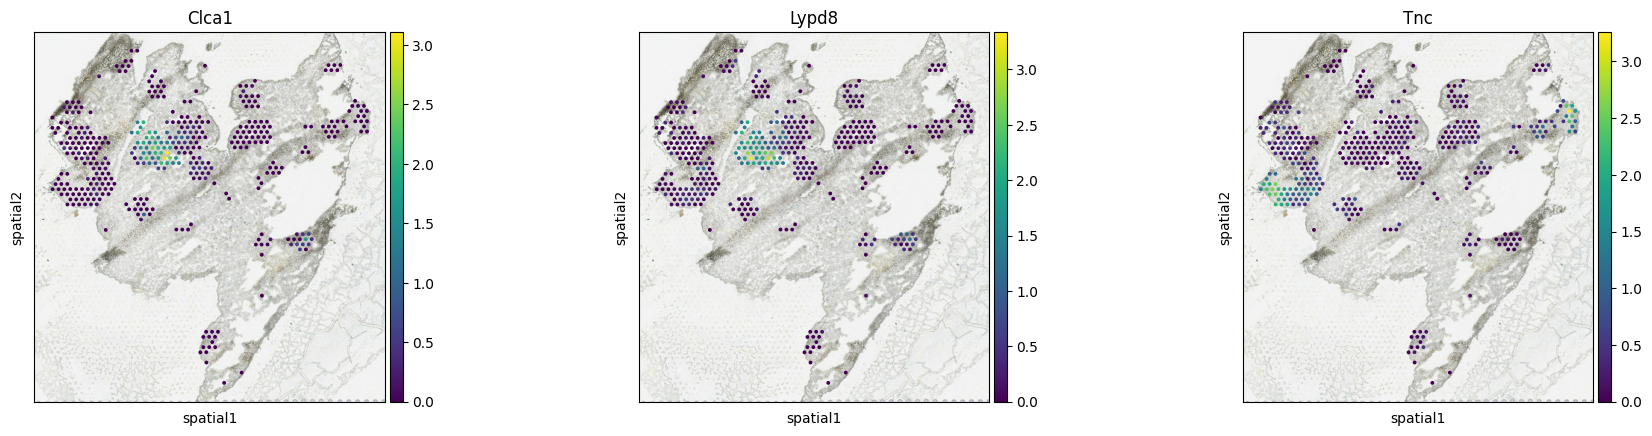

In [15]:
sc.pl.spatial(adata_rna, img_key="hires", color= ["Clca1", "Lypd8", "Tnc"])

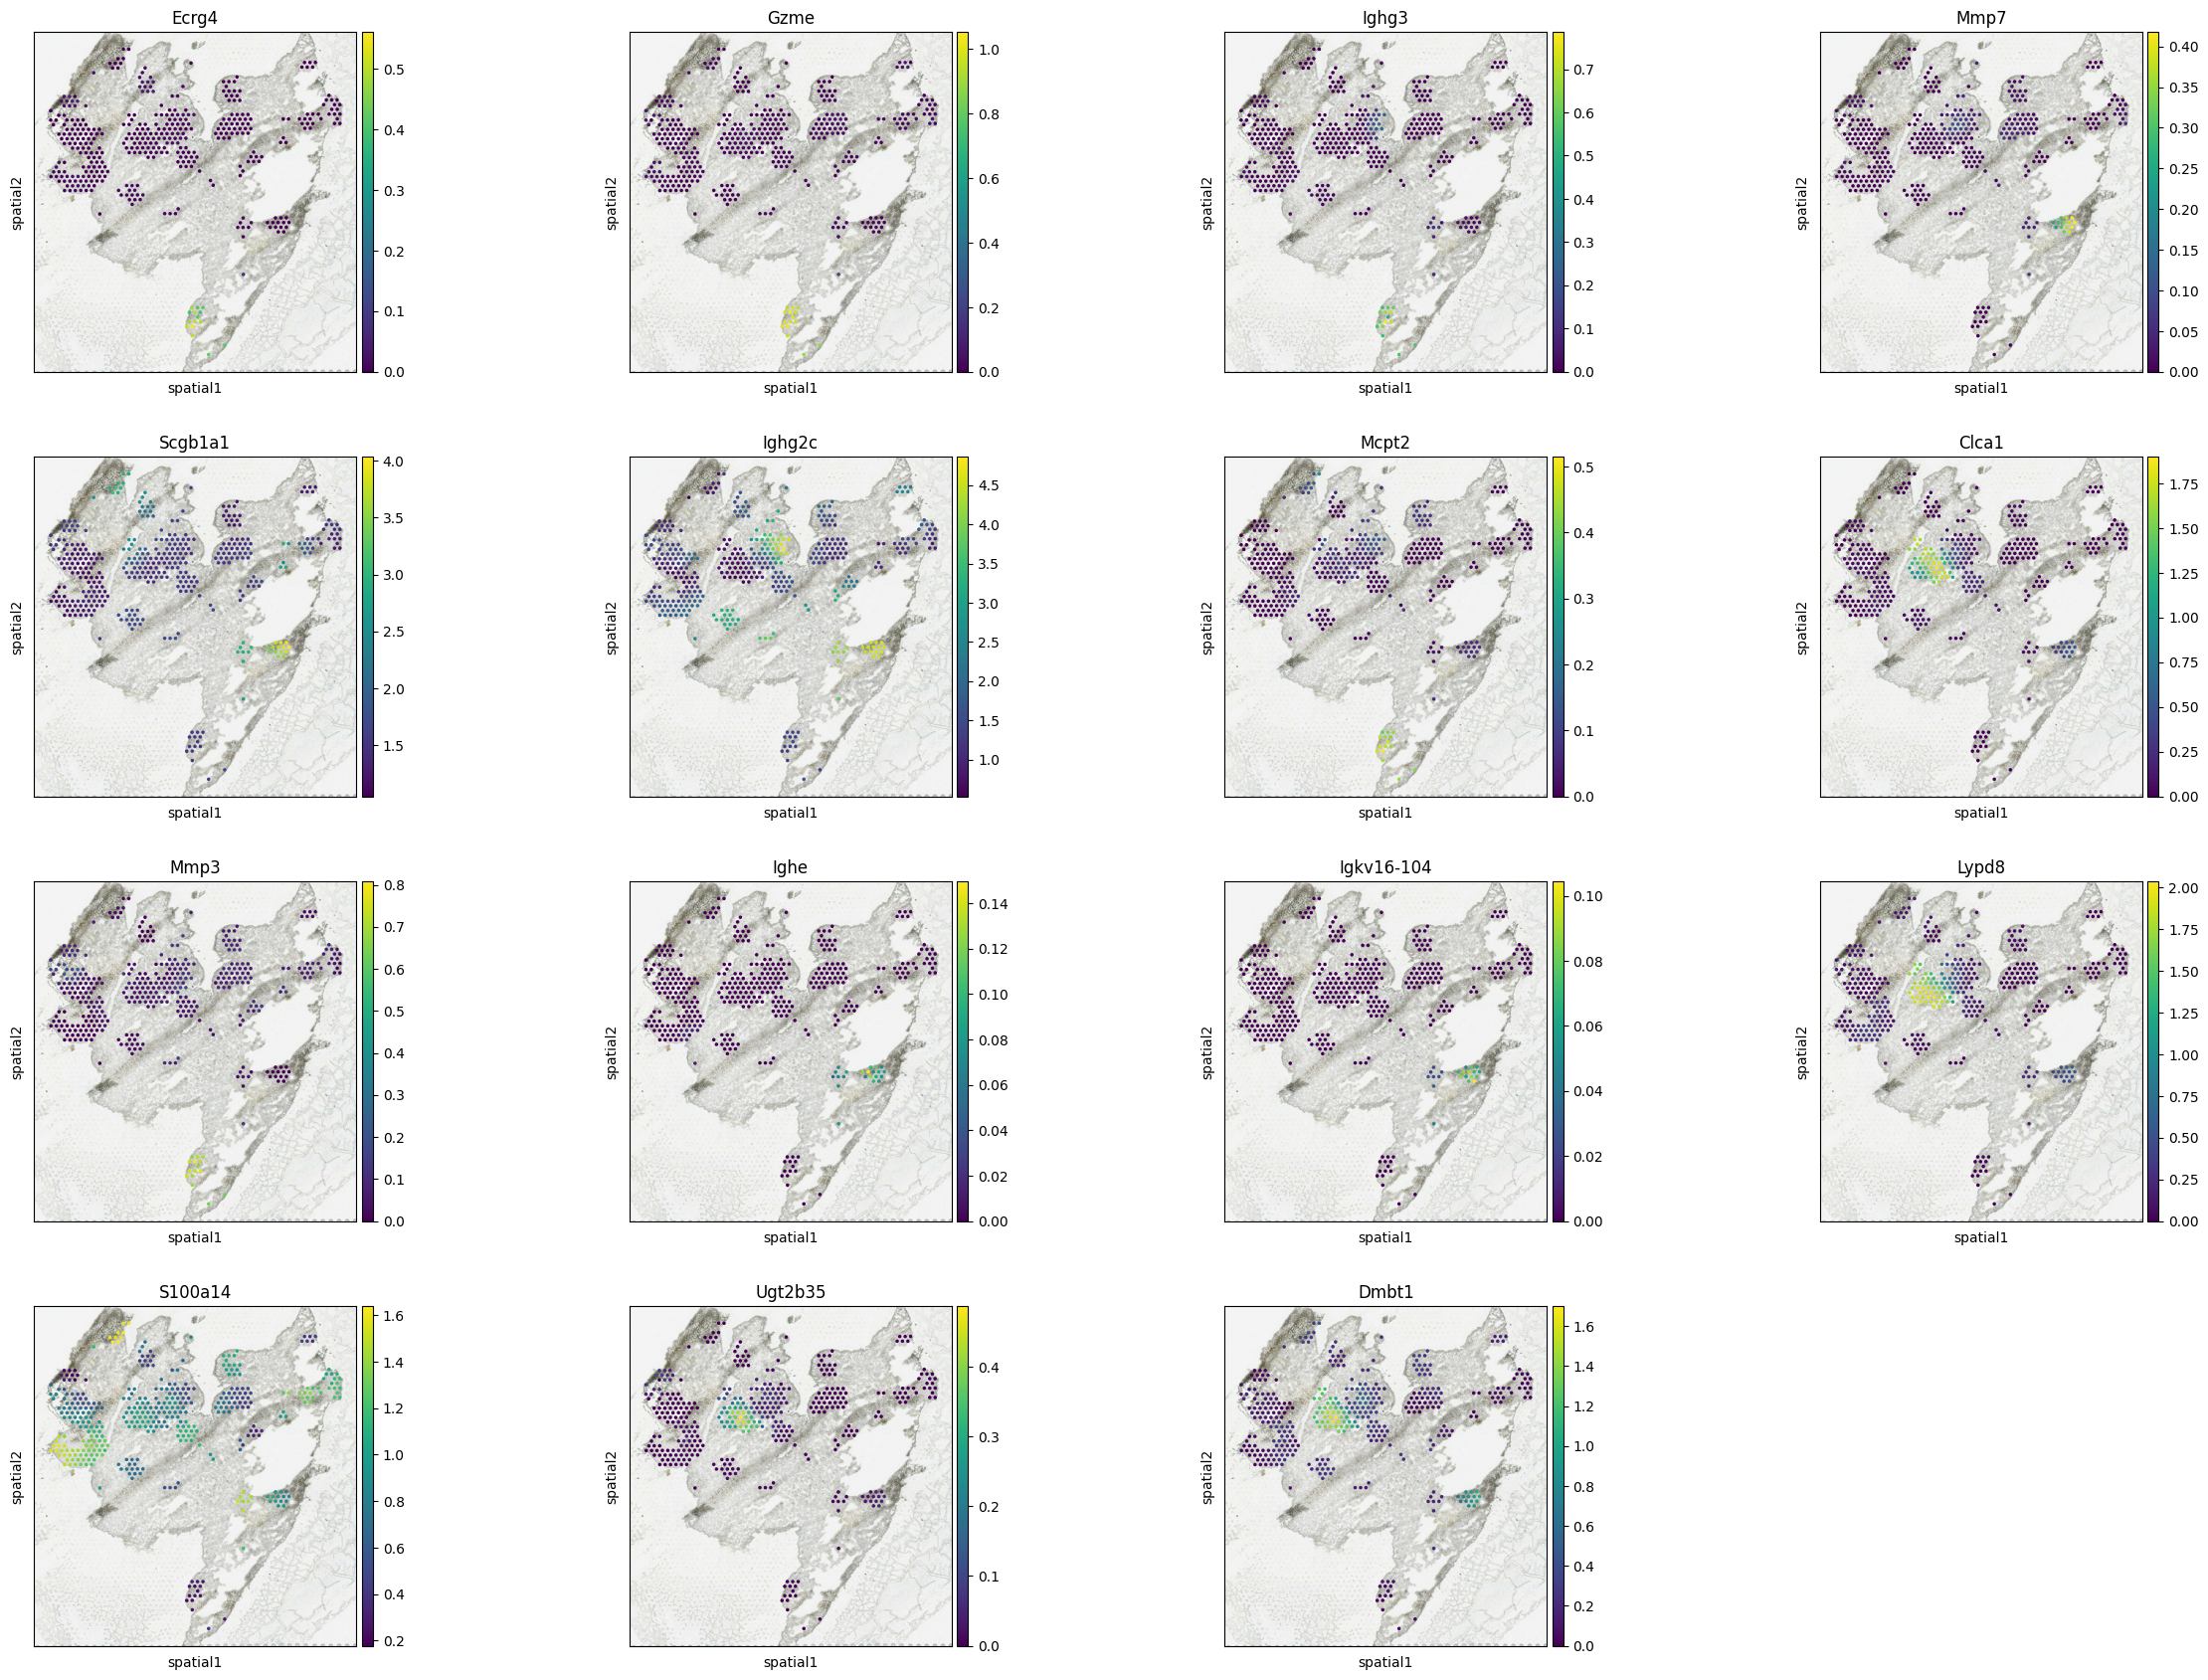

In [26]:
sc.pl.spatial(adata_niche, img_key="hires", color= ["Ecrg4", "Gzme", "Ighg3", "Mmp7", "Scgb1a1", "Ighg2c", "Mcpt2", "Clca1", "Mmp3", "Ighe", "Igkv16-104", "Lypd8", "S100a14", "Ugt2b35", "Dmbt1"])

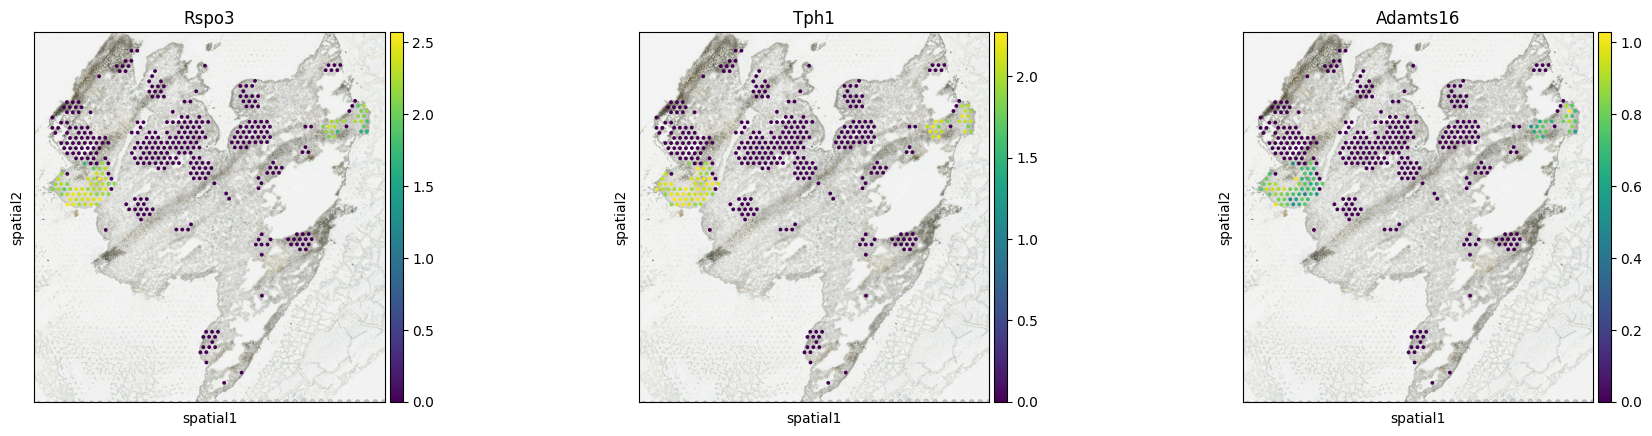

In [19]:
sc.pl.spatial(adata_activity, img_key="hires", color= ["Rspo3", "Tph1", "Adamts16"])

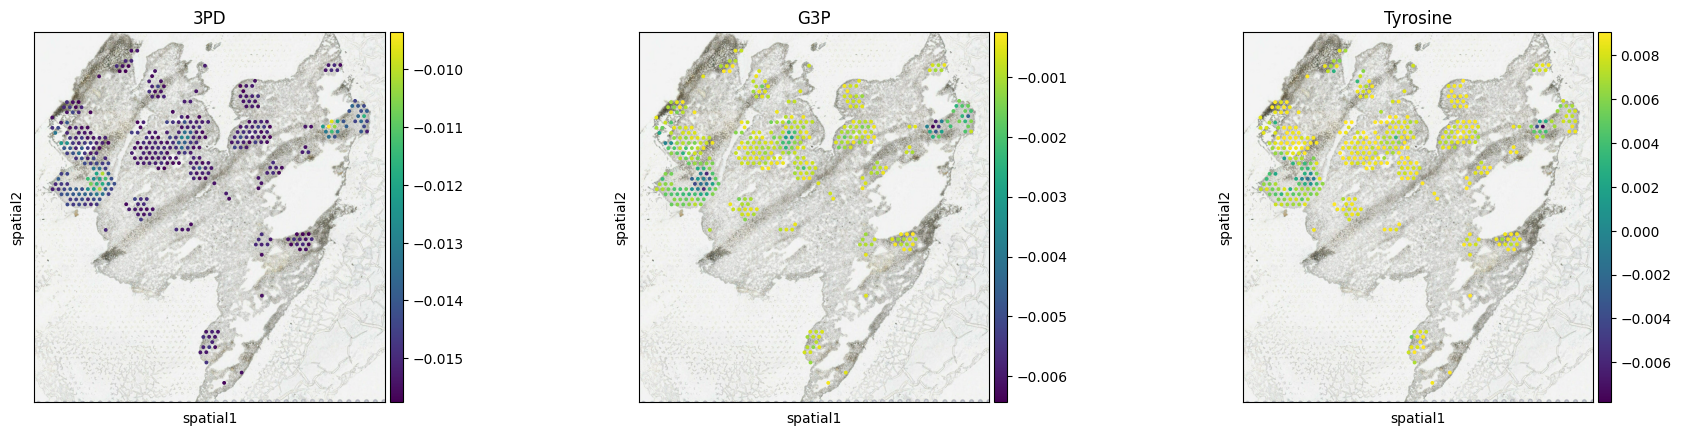

In [20]:
sc.pl.spatial(adata_flux, img_key="hires", color= ["3PD", "G3P", "Tyrosine"])

## Tgf signaling

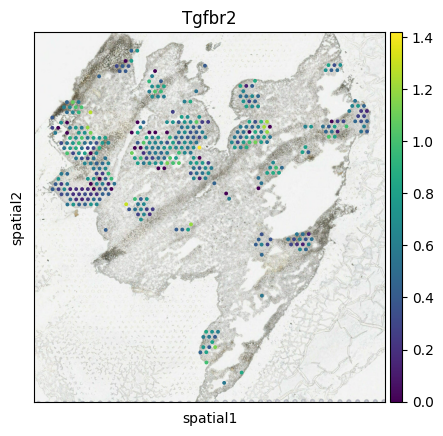

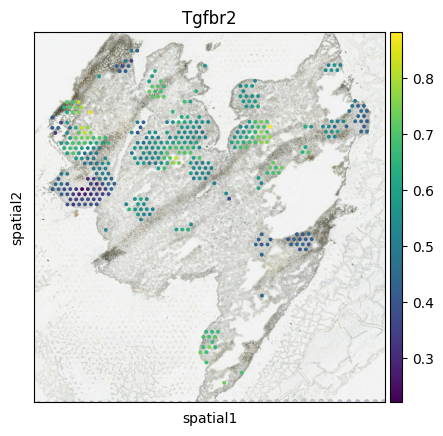

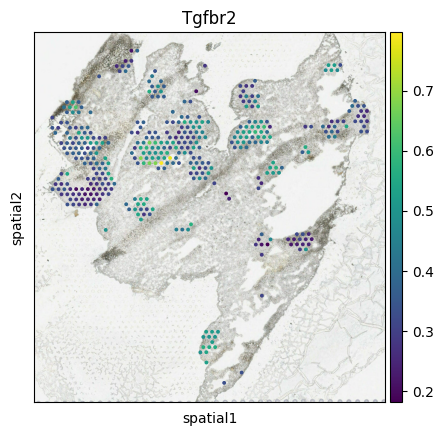

In [27]:
sc.pl.spatial(adata_rna, img_key="hires", color= ["Tgfbr2"])
sc.pl.spatial(adata_niche, img_key="hires", color= ["Tgfbr2"])
sc.pl.spatial(adata_activity, img_key="hires", color= ["Tgfbr2"])